In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
from utils import plot, rolling_sharpe, plot_rolling_sharpe, plot_rolling_vol
%matplotlib inline

In [2]:
cash = 80000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-07-10_16-39_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
micro_contracts = df[df.contract.str.startswith('M')]
macro_contracts = df[~df.contract.str.startswith('M')]
micro_contracts['amount'] /= 10
df = pd.concat([macro_contracts, micro_contracts]).sort_index()
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [4]:
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
time,,,,,,,,,
2018-06-01 12:51:30,GC,SELL,2.0,1301.6,1,ENTRY,4.84,0.00,80000.00
2018-06-01 12:51:30,GC,SELL,0.7,1301.6,2,ENTRY,3.29,0.00,80000.00
2018-06-01 14:33:30,GC,BUY,0.7,1296.7,4,STOP-LOSS,3.29,336.42,81306.74
2018-06-01 14:33:30,GC,BUY,2.0,1296.7,3,STOP-LOSS,4.84,970.32,80970.32
2018-06-01 15:35:30,NQ,BUY,0.3,7029.5,6,ENTRY,1.41,0.00,81306.74
...,...,...,...,...,...,...,...,...,...
2019-12-30 16:16:30,NQ,BUY,0.8,8701.0,8585,STOP-LOSS,3.76,84.48,289832.80
2019-12-30 16:19:30,YM,SELL,7.0,28424.0,8586,ENTRY,14.70,0.00,289832.80
2019-12-30 16:19:30,YM,SELL,0.7,28424.0,8587,ENTRY,3.29,0.00,289832.80


In [5]:
pnl = df.groupby('contract').realizedPNL.sum()
pnl['total'] = pnl.sum()
pnl

contract
ES        47787.10
GC        -5891.62
NQ       102907.04
YM        63993.30
total    208795.82
Name: realizedPNL, dtype: float64

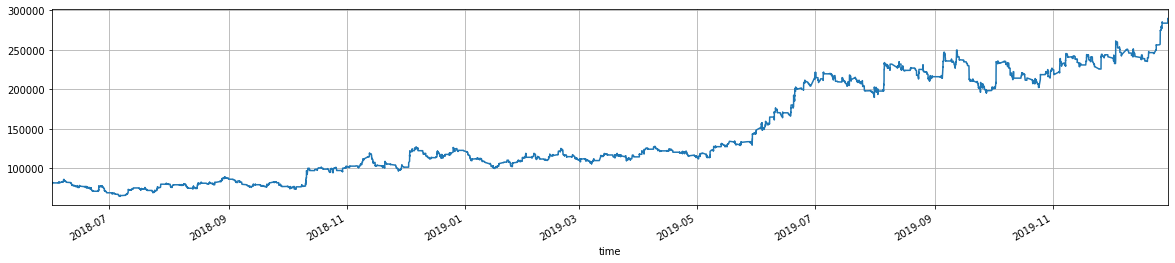

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

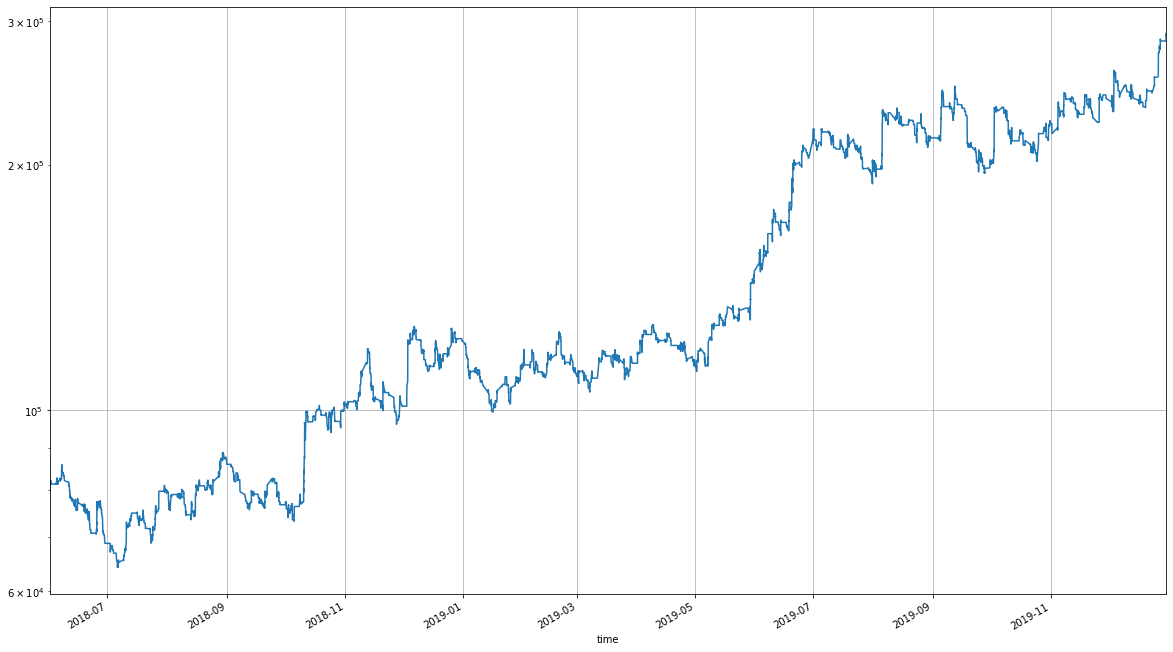

In [7]:
df.cash.plot(figsize=(20,12), grid=True, logy=True);

In [8]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [9]:
#monthly average number of transactions
daily_count = df.groupby('contract').action.resample('B').count()
zero_index = set(daily_count.index.get_level_values(0))
monthly_count = daily_count.groupby('contract').resample('M', level=1).mean()
average_monthly_contracts = pd.DataFrame({contract: monthly_count[contract] for contract in zero_index})
average_monthly_contracts

,YM,NQ,ES,GC
time,,,,
2018-06-30,4.095238,15.523810,2.476190,4.000000
2018-07-31,2.181818,11.545455,1.090909,4.545455
2018-08-31,3.217391,10.260870,1.913043,4.695652
2018-09-30,3.800000,10.800000,2.200000,4.800000
2018-10-31,4.695652,14.086957,2.869565,3.826087
2018-11-30,3.272727,9.363636,2.181818,3.909091
2018-12-31,5.428571,10.000000,3.047619,4.761905
2019-01-31,3.130435,8.956522,2.260870,4.000000
2019-02-28,3.400000,8.000000,2.300000,4.200000


In [10]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     910
 GC    1666
 NQ    4450
 YM    1540
 Name: action, dtype: int64, 8566)

In [11]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES     2.208738
 GC     4.043689
 NQ    10.800971
 YM     3.737864
 Name: action, dtype: float64, 20.79126213592233)

In [12]:
# commission paid
comm = df.groupby('contract').commission.sum()
comm['total'] = comm.sum()
comm

contract
ES        3917.90
GC        9606.62
NQ       19595.46
YM        7018.70
total    40138.68
Name: commission, dtype: float64

In [13]:
# commission paid as percent of pnl
round((comm/pnl) *100, 1)

contract
ES         8.2
GC      -163.1
NQ        19.0
YM        11.0
total     19.2
dtype: float64

In [14]:
# per trade stats (pro rated per macro contract)
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss', 
                                'win_ratio', 'EV/contract', 'contracts_per_position', 'number_of_positions', 
                                'number_of_contracts'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    d['pnl_per_contract'] = d.realizedPNL / d.amount
    row['average_PNL'] = round(d['pnl_per_contract'].mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0])['pnl_per_contract'].mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0])['pnl_per_contract'].mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV/contract'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['contracts_per_position'] = round(d.amount.sum() / d.amount.count(), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    row['number_of_contracts'] = d.amount.sum()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV/contract,contracts_per_position,number_of_positions,number_of_contracts
GC,0.36,-9.10,430.13,-260.20,1.65,-11.68,2.15,833.0,1793.3
NQ,0.39,26.21,387.71,-206.78,1.87,25.07,1.83,2225.0,4073.9
YM,0.39,47.66,566.99,-283.83,2.00,47.99,1.93,770.0,1488.5
ES,0.43,39.47,793.05,-520.67,1.52,44.23,1.81,455.0,824.5
total,0.39,24.61,474.75,-262.81,1.81,24.84,1.91,4283.0,8180.2


In [15]:
edge = results['win_ratio'] - ((1-results['success_rate'])/ results['success_rate'])
edge

GC      -0.127778
NQ       0.305897
YM       0.435897
ES       0.194419
total    0.245897
dtype: float64

In [16]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.00,5226.96,3102.32,-3341.12,1247.04
2018-06-04,0.00,0.00,792.80,0.00,198.20
2018-06-05,2268.88,-3413.04,-1807.20,4930.88,494.88
2018-06-06,0.00,-2441.04,1247.60,1498.88,76.36
2018-06-07,6558.88,-3436.56,-2711.44,7664.64,2018.88
...,...,...,...,...,...
2019-12-24,26764.16,13445.84,0.00,-639.60,9892.60
2019-12-25,0.00,0.00,0.00,0.00,0.00
2019-12-26,0.00,58966.08,14268.48,0.00,18308.64


In [17]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.000000,0.016334,0.009695,-0.010441,0.015588
2018-06-04,0.000000,0.000000,0.002439,0.000000,0.002439
2018-06-05,0.006964,-0.010476,-0.005547,0.015136,0.006076
2018-06-06,0.000000,-0.007448,0.003806,0.004573,0.000932
2018-06-07,0.019993,-0.010475,-0.008265,0.023363,0.024616
...,...,...,...,...,...
2019-12-24,0.027149,0.013639,0.000000,-0.000649,0.040139
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.057506,0.013915,0.000000,0.071421


In [18]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

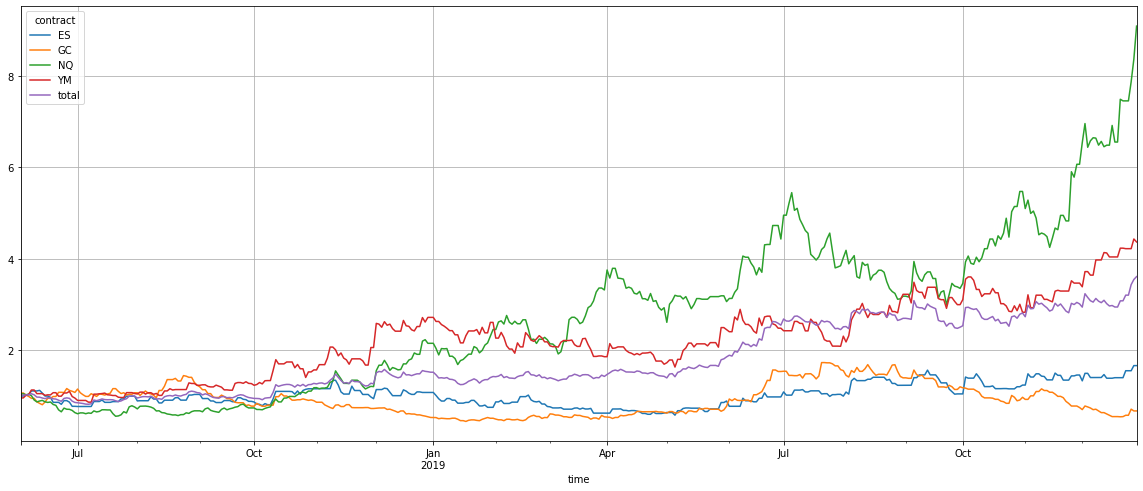

In [19]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [20]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,0.000161,0.283346,0.402522,0.697750
GC,0.000161,1.000000,0.056694,0.007697,0.421146
NQ,0.283346,0.056694,1.000000,0.258085,0.662253
YM,0.402522,0.007697,0.258085,1.000000,0.669895
total,0.697750,0.421146,0.662253,0.669895,1.000000


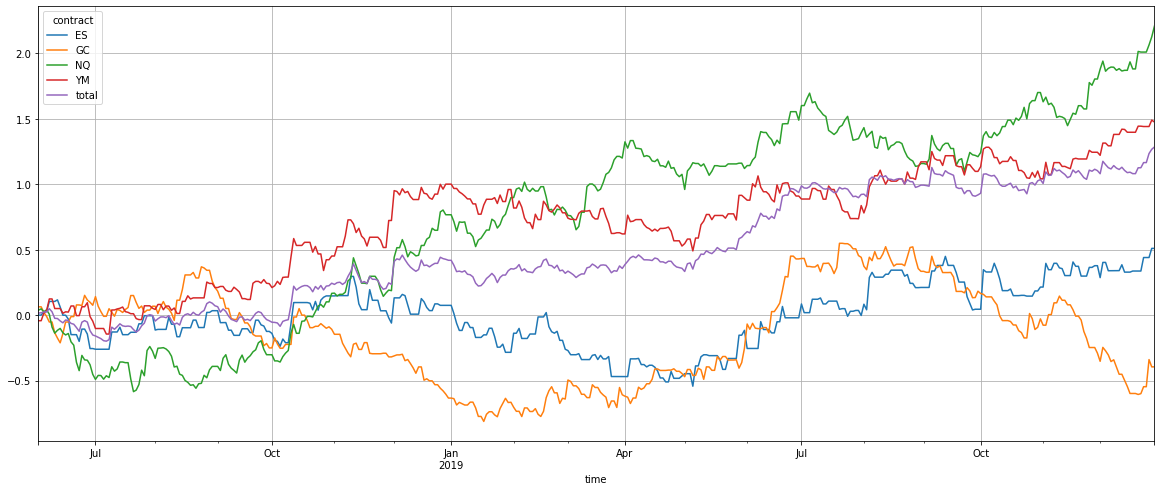

In [21]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

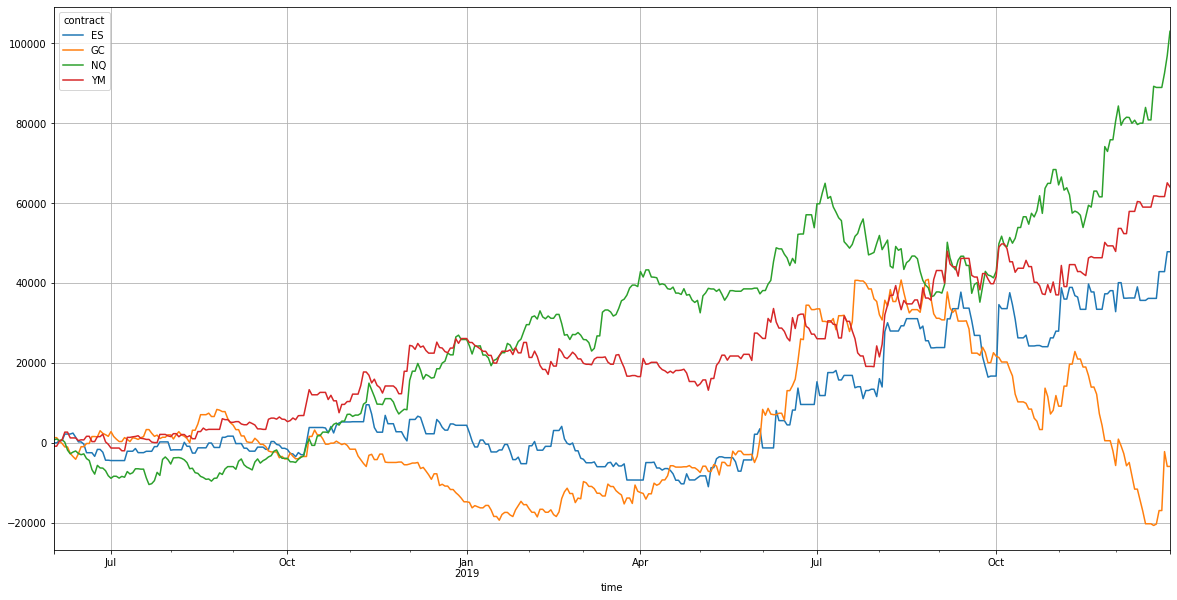

In [22]:
# dollar returns cummulative
by_contract.resample('B').sum().drop('total', axis=1).cumsum().plot(figsize=(20,10), grid=True);

In [23]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.365708,-0.214646,2.856325,1.463668,1.192783
Cumulative returns,0.664559,-0.326341,8.085468,3.367226,2.609948
Annual volatility,0.877736,0.805971,0.863404,0.805926,0.520747
Sharpe ratio,0.768669,0.083740,1.982443,1.504181,1.760015
Calmar ratio,0.644270,-0.309791,6.096681,3.664286,5.426491
Stability,0.214068,0.009643,0.898170,0.826047,0.926572
Max drawdown,-0.567631,-0.692874,-0.468505,-0.399441,-0.219807
Omega ratio,1.197894,1.016210,1.439110,1.363545,1.388315
Sortino ratio,1.412690,0.150753,3.559732,2.945923,3.547939
Skew,1.787735,1.578491,1.033543,1.447400,1.774032


In [24]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,GC,NQ,YM,total
Annual return,0.156043,-0.003111,0.498691,0.326998,1.192783
Cumulative returns,0.267528,-0.005082,0.937650,0.588120,2.609948
Annual volatility,0.219434,0.201493,0.215851,0.201482,0.520747
Sharpe ratio,0.768669,0.083740,1.982443,1.504181,1.760015
Calmar ratio,0.950042,-0.012791,3.614960,3.121580,5.426491
Stability,0.545012,0.125437,0.922604,0.886359,0.926572
Max drawdown,-0.164249,-0.243241,-0.137952,-0.104754,-0.219807
Omega ratio,1.197894,1.016210,1.439110,1.363545,1.388315
Sortino ratio,1.412690,0.150753,3.559732,2.945923,3.547939
Skew,1.787735,1.578491,1.033543,1.447400,1.774032


In [25]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,-5.71,2.37,-10.15,-0.72,-14.08
2018-07-31,6.78,0.18,5.48,3.02,16.08
2018-08-31,1.50,4.39,-2.56,4.36,7.67
2018-09-30,-3.62,-10.63,2.67,0.96,-10.80
2018-10-31,7.76,4.28,12.97,6.28,33.17
2018-11-30,-4.26,-4.86,1.08,7.96,-0.83
2018-12-31,4.10,-7.36,16.92,8.01,20.14
2019-01-31,-8.22,-0.58,3.85,-0.70,-6.21
2019-02-28,1.26,0.98,-2.04,-3.68,-3.45


In [26]:
monthly_returns.total.mean(), monthly_returns.total.median()

(7.932631578947367, 7.090000000000001)

In [27]:
monthly_returns.sort_values('total', ascending = False).total

time
2019-06-30    37.39
2018-10-31    33.17
2019-05-31    29.74
2018-12-31    20.14
2019-12-31    19.79
2018-07-31    16.08
2019-10-31    12.38
2018-08-31     7.67
2019-08-31     7.36
2019-11-30     7.09
2019-03-31     3.76
2019-04-30     0.12
2018-11-30    -0.83
2019-07-31    -1.41
2019-02-28    -3.45
2019-01-31    -6.21
2019-09-30    -7.19
2018-09-30   -10.80
2018-06-30   -14.08
Name: total, dtype: float64

In [28]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        27.0
GC        -1.0
NQ        94.0
YM        59.0
total    261.0
dtype: float64

In [29]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:45:30,ES,BUY,2890.75,14583.20
2019-12-26 17:19:00,GC,SELL,1514.20,14041.28
2019-08-05 21:19:30,ES,BUY,2840.75,13833.20
2019-06-20 03:04:00,GC,SELL,1392.80,12580.64
2019-11-26 02:48:30,NQ,SELL,8407.50,11254.80
...,...,...,...,...
2019-10-10 02:00:00,ES,BUY,2904.00,-3616.80
2019-08-26 02:27:30,ES,BUY,2834.00,-3666.80
2019-09-13 19:42:00,ES,SELL,3009.00,-3700.20


In [30]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2019-09-05,7173.82,6986.74,10573.68,7977.84,32712.08
2019-10-02,17859.74,-295.98,6890.00,7296.28,31750.04
2019-08-05,13833.20,4940.64,1215.50,7391.34,27380.68
2019-12-03,7257.92,6600.82,3767.36,5763.04,23389.14
2019-06-20,5499.12,4550.64,7191.12,3313.62,20554.50
...,...,...,...,...,...
2019-09-23,0.00,-567.72,-4897.48,-3212.10,-8677.30
2019-08-28,-1776.68,-4798.24,-2185.04,-540.38,-9300.34
2019-10-10,-3616.80,-4558.72,1218.96,-2624.26,-9580.82


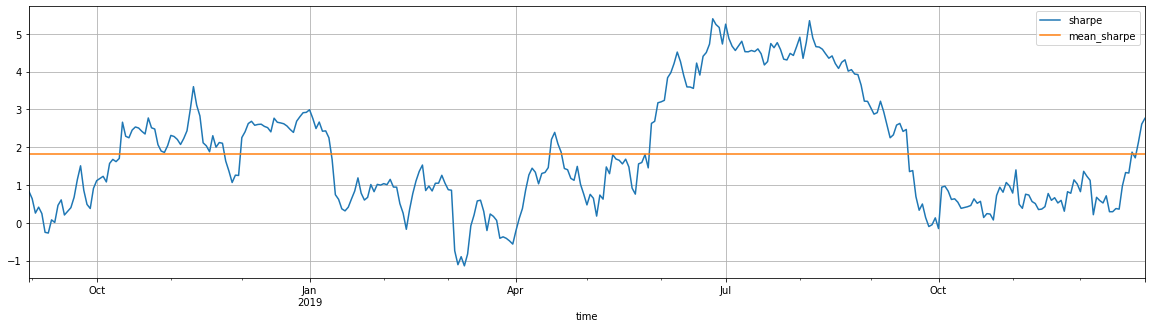

In [31]:
plot_rolling_sharpe(returns.total, 3)

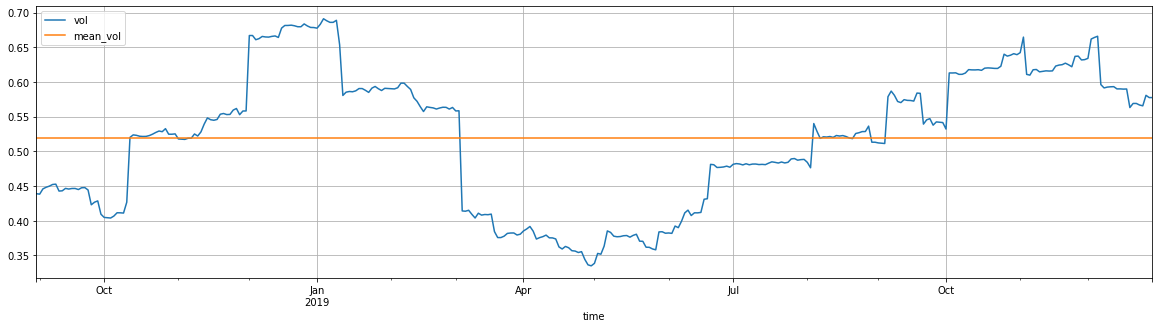

In [32]:
plot_rolling_vol(returns.total, 3)